## Regression test suite: Test of POPIII star input

Test of SSP with POPIII yields. Focus are basic GCE features.
You can find the documentation <a href="doc/sygma.html">here</a>.


 

In [3]:
import sygma as s
reload(s)
#from imp import *
#s=load_source('sygma','/home/nugrid/nugrid/SYGMA/SYGMA_online/SYGMA_dev/sygma.py')
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Results

$\odot$ Evolution of ISM fine

$\odot$ Sources of massive and AGB stars distinguished

$\odot$ Test of final mass of ISM for different IMF boundaries

$\odot$ Test of Salpeter, Chabrier, Kroupa IMF by checking  the evolution of ISM mass (incl. alphaimf)

$\odot$ Test if SNIa on/off works

$\odot$ Test of the three SNIa implementations, the evolution of SN1a contributions

$\odot$ Test of parameter tend, dt and special_timesteps

$\odot$ Test of parmeter mgal

$\odot$ Test of netyields_on

TODO: test non-linear yield fitting (hard set in code right now, no input parameter provided)


### IMF notes:

The IMF allows to calculate the number of stars $N_{12}$ in the mass interval [m1,m2] with

(I) $N_{12}$ = k_N $\int _{m1}^{m2} m^{-2.35} dm$ 

Where k_N is the normalization constant. It can be derived from the total amount of mass of the system $M_{tot}$
since the total mass $M_{12}$ in the mass interval above can be estimated with

(II) $M_{12}$ = k_N $\int _{m1}^{m2} m^{-1.35} dm$

With a total mass interval of [1,30] and $M_{tot}=1e11$ the $k_N$ can be derived:

$1e11 = k_N/0.35 * (1^{-0.35} - 30^{-0.35})$

### Final mass

In [2]:
k_N=1e11*0.35/ (10**-0.35 - 30**-0.35) #(I)
N_tot=k_N/1.35 * (10**-1.35 - 30**-1.35) #(II)
Yield_tot=0.1*N_tot

Includes stars from 10Msun to 30Msun (upper end consistent with higher Z). 

At ~5e6 M30 star starts to contribute. Need to resolve steps between masses and hence chhose small constant time interval for s2 run.

In [3]:
reload(s)
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e6,tend=1.3e10,imf_type='salpeter',imf_yields_range_pop3=[10,30],imf_bdys_pop3=[10,30],pop3_table='yield_tables/popIII_h1.txt',table='yield_tables/isotope_yield_table_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab1.0E-04GN93_alpha_h1.ppn')
s2=s.sygma(iolevel=0,mgal=1e11,dt=1e5,tend=3e7,special_timesteps=-1,imf_type='salpeter',imf_yields_range_pop3=[10,30],imf_bdys_pop3=[10,30],pop3_table='yield_tables/popIII_h1.txt',table='yield_tables/isotope_yield_table_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab1.0E-04GN93_alpha_h1.ppn')
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]

SYGMA run in progress..
   SYGMA run completed - Run time: 0.17s
SYGMA run in progress..
   SYGMA run completed - Run time: 1.78s


In [4]:
print Yield_tot_sim
print Yield_tot
print 'ratio should be 1 : ',Yield_tot_sim/Yield_tot

627865031.179
627865031.179
ratio should be 1 :  1.0


### Test of distinguishing between massive PoPIII and other sources

No production of any source, except massive stars expected. Massive stars produce all H.

In [5]:
print s1.history.ism_iso_yield_agb[-1][0]
print 'should be 1: ',s1.history.ism_iso_yield_massive[-1][0]/Yield_tot
print 'No SNIa contribution:',s1.history.ism_iso_yield_1a[-1][0]

0.0
should be 1:  1.0
No SNIa contribution: 0.0


(1000000.0, 1000000000.0)

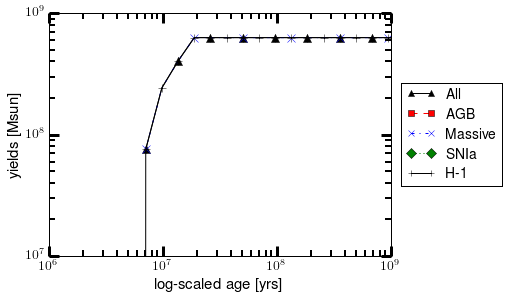

In [6]:
s1.plot_totmasses(fig=1,source='all',markevery=2,marker='^')
s1.plot_totmasses(fig=1,source='agb')
s1.plot_totmasses(fig=1,source='massive',marker='x',markevery=3)
s1.plot_totmasses(fig=1,source='sn1a',marker='D')
s1.plot_mass(fig=1,specie='H-1',marker='+',markevery=1)
#plt.legend(loc=7,fontsize=14)
#mpld3.display()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(1e6,1e9)

Higher resolution:

(6000000.0, 30000000.0)

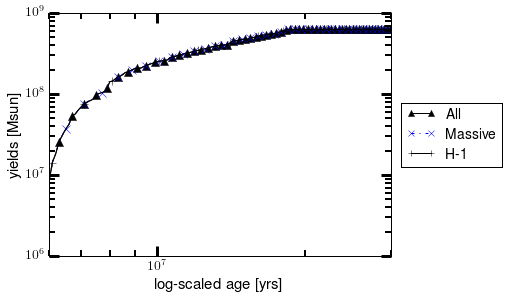

In [8]:
s2.plot_totmasses(fig=1,source='all',markevery=4,marker='^')
s2.plot_totmasses(fig=1,source='massive',marker='x',markevery=6)
s2.plot_mass(fig=1,specie='H-1',marker='+',markevery=10)
#plt.legend(loc=7,fontsize=14)
#mpld3.display()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(6e6,3e7)

### Calculating yield ejection over time 

#### Check grid lifetime plot

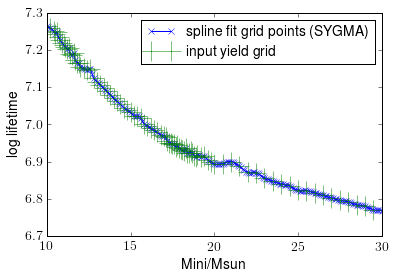

In [9]:
import read_yields as ry
y=ry.read_nugrid_yields('yield_tables/popIII_h1.txt')
zm_lifetime_grid=s1.zm_lifetime_grid_current
idx_z = (np.abs(zm_lifetime_grid[0]-0.0001)).argmin() #Z=0
grid_masses=zm_lifetime_grid[1][::-1]
grid_lifetimes=zm_lifetime_grid[2][idx_z][::-1]
plt.plot(grid_masses,grid_lifetimes,label='spline fit grid points (SYGMA)',marker='x')
m=[]
ages=[]
for k in range(len(y.table_mz)):
    m_ini=float(y.table_mz[k].split(',')[0].split('=')[1])
    if m_ini>=30:
        continue
    m.append(m_ini)
    ages.append(y.age[k])
plt.plot(np.array(m),np.log10(np.array(ages)),marker='+',markersize=20,label='input yield grid',linestyle='None')
plt.xlabel('Mini/Msun')
plt.ylabel('log lifetime');plt.legend(prop={'size':14})

(5000000.0, 30000000.0)

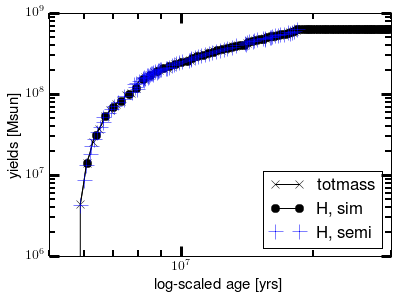

In [10]:
s2.plot_totmasses(fig=2,marker='x',label='totmass',markevery=2)
s2.plot_mass(fig=2,specie='H',label='H, sim',color='k',shape='-',marker='o',markevery=3)
import read_yields as ry
y=ry.read_nugrid_yields('yield_tables/popIII_h1.txt')
m=[]
ages=[]
for k in range(len(y.table_mz)):
    m_ini=float(y.table_mz[k].split(',')[0].split('=')[1])
    if m_ini>=30:
        continue
    m.append(m_ini)
    ages.append(y.age[k])
    #print m[-1],ages[-1]
def yields(m,k_N):
    return ( k_N/1.35 * (m**-1.35 - 30.**-1.35) ) * 0.1
yields1=[]
for m1 in m:
    yields1.append(yields(m1,k_N))
plt.plot(ages,yields1,marker='+',linestyle='',markersize=15,label='H, semi')
plt.legend(loc=4)
plt.xlim(5e6,3e7)

### Test of parameter imf_bdys: Selection of different mass intervals

#### Select imf_bdys=[15,30]

In [11]:
k_N=1e11*0.35/ (15**-0.35 - 30**-0.35)
N_tot=k_N/1.35 * (15**-1.35 - 30**-1.35)
Yield_tot=0.1*N_tot

In [12]:
##reload(chem_evol)
#dreload(s)
import sygma as s
reload(s)
s1=s.sygma(iolevel=1,mgal=1e11,iniZ=0,dt=1e7,tend=1.3e10,imf_type='salpeter',imf_bdys=[10,30],imf_bdys_pop3=[15,30],pop3_table='yield_tables/popIII_h1.txt',table='yield_tables/isotope_yield_table_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab1.0E-04GN93_alpha_h1.ppn')
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]

Warning - Use isotopes with care.
['H-1']
Use initial abundance of  yield_tables/iniabu/iniab1.0E-04GN93_alpha_h1.ppn
Number of timesteps:  3.0E+01
### Start with initial metallicity of  0.0000E+00
###############################
SYGMA run in progress..
################## Star formation at  1.000E+07 (Z=0.0000E+00) of  1.0
Mass locked away: 1.000E+11 , new ISM mass: 0.000E+00
Taking POPIII yields from yield_tables/popIII_heger10.txt
Currently only PopIII massive stars between 10Msun and 100Msun with their yielda contributions included
 lower IMF minimum (imf_bdys) fixed to 10Msun for now
Stars under consideration (take into account user-selected imf ends):
[15.0, 15.2, 15.4, 15.6, 15.8, 16.0, 16.2, 16.4, 16.6, 16.8, 17.0, 17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18.0, 18.1, 18.2, 18.3, 18.4, 18.5, 18.6, 18.7, 18.8, 18.9, 19.0, 19.2, 19.4, 19.6, 19.8, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 25.5, 26.0, 26.5, 27.0, 27.5, 28.0, 28.5, 29.0, 29.5, 30.0

In [13]:
print 'Sould be 1:' ,Yield_tot_sim/Yield_tot

Sould be 1: 1.0


#### Select imf_bdys=[10,15]

In [14]:
k_N=1e11*0.35/ (10**-0.35 - 15**-0.35)
N_tot=k_N/1.35 * (10**-1.35 - 15**-1.35)
Yield_tot=0.1*N_tot

In [17]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='salpeter',imf_yields_range_pop3=[10,30],imf_bdys_pop3=[10,15],pop3_table='yield_tables/popIII_h1.txt',table='yield_tables/isotope_yield_table_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab1.0E-04GN93_alpha_h1.ppn')
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]

SYGMA run in progress..
   SYGMA run completed - Run time: 0.14s


##### Select imf_bdys=[10,100] ; NEEDS TO BE TESTED

In [18]:
k_N=1e11*0.35/ (10**-0.35 - 100**-0.35) #(I)
N_tot=k_N/1.35 * (10**-1.35 - 30**-1.35) #(II)
Yield_tot=0.1*N_tot

In [20]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='salpeter',imf_bdys_pop3=[10,100],pop3_table='yield_tables/popIII_h1.txt',table='yield_tables/isotope_yield_table_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab1.0E-04GN93_alpha_h1.ppn')
#imf_yields_range_pop3=[10,30],
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]

SYGMA run in progress..
   SYGMA run completed - Run time: 0.15s


In [21]:
print s1.imf_bdys,s1.imf_bdys_pop3,s1.imf_yields_range_pop3

[0.1, 100] [10, 100] [10, 30]


In [22]:
print Yield_tot_sim
print Yield_tot
print 'Sould be 1:' ,Yield_tot_sim/Yield_tot

362227312.051
362227312.051
Sould be 1: 1.0


### Test of parameter imf_type: Selection of different IMF types

#### alphaimf

In [23]:
alphaimf = 1.5 #Set test alphaimf

In [24]:
k_N=1e11*(alphaimf-2)/ (-10**-(alphaimf-2) + 30**-(alphaimf-2))
N_tot=k_N/(alphaimf-1) * (-10**-(alphaimf-1) + 30**-(alphaimf-1))
Yield_tot=0.1*N_tot

In [26]:
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='alphaimf',alphaimf=1.5,imf_bdys_pop3=[10,30],pop3_table='yield_tables/popIII_h1.txt',table='yield_tables/isotope_yield_table_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab1.0E-04GN93_alpha_h1.ppn')
Yield_tot_sim=s1.history.ism_iso_yield[-1][0]

SYGMA run in progress..
   SYGMA run completed - Run time: 0.15s


In [27]:
print 'Should be 1 :',Yield_tot/Yield_tot_sim

Should be 1 : 1.0


### Testing other IMF type does not make sense since range only considers massive stars

### Test of parameter sn1a_on: on/off mechanism : There should be no SNIa contribution

In [29]:
reload(s)
s1=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='alphaimf',imf_bdys_pop3=[10,30],pop3_table='yield_tables/popIII_h1.txt',table='yield_tables/isotope_yield_table_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab1.0E-04GN93_alpha_h1.ppn')
s2=s.sygma(iolevel=0,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='alphaimf',imf_bdys_pop3=[10,30],pop3_table='yield_tables/popIII_h1.txt',table='yield_tables/isotope_yield_table_h1.txt',sn1a_on=True, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab1.0E-04GN93_alpha_h1.ppn')


SYGMA run in progress..
   SYGMA run completed - Run time: 0.15s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.15s


In [30]:
print 'Should be 0:',(s1.history.ism_elem_yield_1a[0]),(s1.history.ism_elem_yield_1a[-1])
print (s1.history.ism_elem_yield[0]),(s1.history.ism_elem_yield[-1])
print 'Should be 0:',(s2.history.ism_elem_yield_1a[0]),(s2.history.ism_elem_yield_1a[-1])
print (s2.history.ism_elem_yield[0]),(s2.history.ism_elem_yield[-1])
print (s1.history.ism_elem_yield[-1][0] + s2.history.ism_elem_yield_1a[-1][0])/s2.history.ism_elem_yield[-1][0]
#s2.plot_mass(specie='H-1',source='sn1a') #plot s1 data  (without sn) cannot be plotted -> error, maybe change plot function?

Should be 0: [0] [0.0]
[100000000000.0] [627865031.17904067]
Should be 0: [0] [0.0]
[100000000000.0] [627865031.17904067]
1.0


# with net yields netyields_on = True

Error - net yields setting not usable with PopIII at the moment.
correct for isotopes


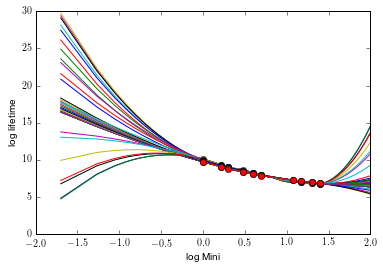

In [2]:
s0=s.sygma(iolevel=0,imf_bdys=[0.01,100],imf_yields_range=[0.02,99],imf_type='chabrier',transitionmass=6,sfr='input',iniZ=0.0,\
        dt=1e7,tend=1.3e10, mgal=1e1,sn1a_on=True,sn1a_rate='exp',exp_dtd=2e9,exclude_masses=[100,6,7],netyields_on=True,pop3_table='yield_tables/popIII_h1.txt')

# End of test suite (for now)

## Test parameter imf_yields_range : Change range of contributing yields: Not yet included!

### yield range [20,30]

In [94]:
s1=s.sygma(iolevel=1,mgal=1e11,dt=1e7,tend=1.3e10,imf_type='salpeter',imf_bdys_pop3=[10,30],imf_yields_range_pop3=[20,30],iniZ=-1,pop3_table='yield_tables/popIII_h1.txt',table='yield_tables/isotope_yield_table_h1.txt',sn1a_on=False, sn1a_table='yield_tables/sn1a_h1.txt', iniabu_table='yield_tables/iniabu/iniab1.0E-04GN93_alpha_h1.ppn')
#Yield_tot_sim=s1.history.ism_iso_yield[-1][0]

################    Start SYGMA simulation   ##############
Stop: Setting of imf_yields_range_pop3 feature not included  yet


In [330]:
k_N=1e11*0.35/ (10**-0.35 - 30**-0.35)
N_tot=k_N/1.35 * (20**-1.35 - 30**-1.35)
Yield_tot=0.1*N_tot

In [331]:
s1.imf_bdys,s1.imf_bdys_pop3,s1.imf_yields_range_pop3

([10, 30], [10, 30], [20, 30])

In [332]:
print 'Sould be 1:' ,Yield_tot_sim/Yield_tot

Sould be 1: 1.0


In [ ]:
yield range [20,30]